<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#realtime-test" data-toc-modified-id="realtime-test-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>realtime test</a></span></li><li><span><a href="#score" data-toc-modified-id="score-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>score</a></span></li><li><span><a href="#plot" data-toc-modified-id="plot-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>plot</a></span><ul class="toc-item"><li><span><a href="#drum-note" data-toc-modified-id="drum-note-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>drum note</a></span></li><li><span><a href="#real-time" data-toc-modified-id="real-time-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>real-time</a></span></li></ul></li></ul></div>

Try id #259

In [1]:
import sys
sys.path.append('..')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
import taiko as tk
from taiko.play import *
from taiko.performance import *
from taiko.model import *
from taiko.database import *
from taiko.tools.config import *
from taiko.tools.score import *
from taiko.visualize import *

from collections import deque
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import posixpath
from scipy.stats import mode
from skimage.io import imshow, imsave, imread

sns.set(font_scale=1.5)

Using TensorFlow backend.


In [3]:
record_df = load_record_df()
record_df = record_df[(record_df['song_id'] >= 1) & (record_df['song_id'] <= 4)]
record_df

,drummer_name,song_id,left_sensor_datetime,right_sensor_datetime,capture_datetime
1,aaaaa,1,L_2018-09-28_111304.csv,R_2018-09-28_111305.csv,capture_2018_09_28_11_13_05
2,aaaaa,2,L_2018-09-28_111610.csv,R_2018-09-28_111611.csv,capture_2018_09_28_11_16_11
3,aaaaa,3,L_2018-09-28_111936.csv,R_2018-09-28_111937.csv,capture_2018_09_28_11_19_37
4,aaaaa,4,L_2018-09-28_112353.csv,R_2018-09-28_112355.csv,capture_2018_09_28_11_23_55
5,aaaaa,1,L_2018-09-28_112912.csv,R_2018-09-28_112913.csv,capture_2018_09_28_11_29_13
6,aaaaa,2,L_2018-09-28_113242.csv,R_2018-09-28_113244.csv,capture_2018_09_28_11_32_44
7,aaaaa,3,L_2018-09-28_113531.csv,R_2018-09-28_113532.csv,capture_2018_09_28_11_35_32
8,aaaaa,4,L_2018-09-28_113909.csv,R_2018-09-28_113910.csv,capture_2018_09_28_11_39_10
9,aaaaa,1,L_2018-09-28_114340.csv,R_2018-09-28_114340.csv,capture_2018_09_28_11_43_41
10,aaaaa,2,L_2018-09-28_114710.csv,R_2018-09-28_114713.csv,capture_2018_09_28_11_47_13


In [4]:
print(record_df.loc[254])

drummer_name                             howeverover
song_id                                            1
left_sensor_datetime         L_2018-09-29_192259.csv
right_sensor_datetime        R_2018-09-29_192300.csv
capture_datetime         capture_2018_09_29_19_23_01
Name: 254, dtype: object


In [5]:
id_ = 254
record_row = record_df.loc[id_]
play = get_play(record_row)
pf = get_performance(play, id_=id_)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


# realtime test

In [6]:
lgbm = LGBM()

train_df = pf.copy()
x = train_df.drop('timestamp', axis=1)
ts = train_df['timestamp']
train_df

100%|██████████| 12/12 [00:00<00:00, 280.10it/s]


,timestamp,L_A_AI,R_A_AI,L_G_AI,R_G_AI,L_AX_AI,R_AX_AI,L_AY_AI,R_AY_AI,L_AZ_AI,...,L_AYZ_CORR,R_AYZ_CORR,L_AZX_CORR,R_AZX_CORR,L_GXY_CORR,R_GXY_CORR,L_GYZ_CORR,R_GYZ_CORR,L_GZX_CORR,R_GZX_CORR
0,1.538220e+09,0.3993,8.0683,0.1777,-0.2667,-0.0627,-3.1961,5.2991,3.9230,0.3868,...,0.3648,7.4341,4.3366,3.9887,-0.3985,-0.3344,0.9076,-0.8008,-0.7999,0.9109
1,1.538220e+09,0.2968,6.5753,-0.0071,-0.2596,0.0209,-2.9309,4.7531,2.8287,0.2867,...,0.3414,3.9673,3.8941,5.0415,-0.7364,-0.7442,0.9246,-0.3106,-0.3892,-0.1100
2,1.538220e+09,0.3036,3.6323,0.0285,-0.2601,0.0541,-0.7620,2.9727,1.2769,0.2606,...,0.3194,4.6265,3.7689,6.3477,0.0977,0.4981,0.7659,0.4606,-0.8544,-0.4267
3,1.538220e+09,0.3755,4.3897,0.0981,-0.3209,0.0624,1.6876,0.6775,-0.0269,0.3567,...,0.4020,4.6265,3.3570,3.2105,0.1229,0.8274,0.5118,0.4853,0.2422,-0.2742
4,1.538220e+09,0.3269,4.6021,0.1474,-0.2007,0.0838,1.8257,-0.4716,-2.6852,0.3279,...,0.2971,5.1392,6.0181,3.7842,-0.2949,0.7350,0.1627,0.2130,0.9423,0.1783
5,1.538220e+09,0.2891,4.1740,0.1951,-0.1341,0.0954,0.7698,0.8467,-3.6754,0.2989,...,0.2643,4.9317,4.6509,4.1504,-0.5270,0.4558,0.3314,0.4528,0.6556,0.5749
6,1.538220e+09,0.3264,3.6185,0.2203,-0.1641,0.1569,1.7676,1.0152,-2.5688,0.3248,...,0.2007,7.7759,5.3711,3.6499,-0.3119,0.2837,0.6399,0.6364,0.1636,0.5367
7,1.538220e+09,0.2837,2.9467,0.1764,-0.1280,0.1624,0.1045,1.4369,-0.1086,0.3170,...,0.1396,6.2500,3.4546,2.2797,-0.3135,-0.5187,0.2705,0.0198,-0.5420,0.4885
8,1.538220e+09,0.2573,3.1576,0.1792,-0.1232,0.1080,-2.4231,1.0317,0.8516,0.2492,...,0.2893,4.4556,5.4749,1.6693,0.1734,0.4826,-0.5334,0.0183,0.3749,0.3321
9,1.538220e+09,0.3268,3.6350,0.2456,-0.1451,0.1409,-3.4073,0.6712,0.4805,0.3342,...,0.1528,1.2573,7.0435,2.6367,0.0586,0.1012,0.5677,0.2726,0.7198,0.5716


In [7]:
hit_type_x = lgbm.predict(x)
train_df['hit_type'] = hit_type_x
train_df

,timestamp,L_A_AI,R_A_AI,L_G_AI,R_G_AI,L_AX_AI,R_AX_AI,L_AY_AI,R_AY_AI,L_AZ_AI,...,R_AYZ_CORR,L_AZX_CORR,R_AZX_CORR,L_GXY_CORR,R_GXY_CORR,L_GYZ_CORR,R_GYZ_CORR,L_GZX_CORR,R_GZX_CORR,hit_type
0,1.538220e+09,0.3993,8.0683,0.1777,-0.2667,-0.0627,-3.1961,5.2991,3.9230,0.3868,...,7.4341,4.3366,3.9887,-0.3985,-0.3344,0.9076,-0.8008,-0.7999,0.9109,0
1,1.538220e+09,0.2968,6.5753,-0.0071,-0.2596,0.0209,-2.9309,4.7531,2.8287,0.2867,...,3.9673,3.8941,5.0415,-0.7364,-0.7442,0.9246,-0.3106,-0.3892,-0.1100,0
2,1.538220e+09,0.3036,3.6323,0.0285,-0.2601,0.0541,-0.7620,2.9727,1.2769,0.2606,...,4.6265,3.7689,6.3477,0.0977,0.4981,0.7659,0.4606,-0.8544,-0.4267,0
3,1.538220e+09,0.3755,4.3897,0.0981,-0.3209,0.0624,1.6876,0.6775,-0.0269,0.3567,...,4.6265,3.3570,3.2105,0.1229,0.8274,0.5118,0.4853,0.2422,-0.2742,0
4,1.538220e+09,0.3269,4.6021,0.1474,-0.2007,0.0838,1.8257,-0.4716,-2.6852,0.3279,...,5.1392,6.0181,3.7842,-0.2949,0.7350,0.1627,0.2130,0.9423,0.1783,0
5,1.538220e+09,0.2891,4.1740,0.1951,-0.1341,0.0954,0.7698,0.8467,-3.6754,0.2989,...,4.9317,4.6509,4.1504,-0.5270,0.4558,0.3314,0.4528,0.6556,0.5749,0
6,1.538220e+09,0.3264,3.6185,0.2203,-0.1641,0.1569,1.7676,1.0152,-2.5688,0.3248,...,7.7759,5.3711,3.6499,-0.3119,0.2837,0.6399,0.6364,0.1636,0.5367,0
7,1.538220e+09,0.2837,2.9467,0.1764,-0.1280,0.1624,0.1045,1.4369,-0.1086,0.3170,...,6.2500,3.4546,2.2797,-0.3135,-0.5187,0.2705,0.0198,-0.5420,0.4885,0
8,1.538220e+09,0.2573,3.1576,0.1792,-0.1232,0.1080,-2.4231,1.0317,0.8516,0.2492,...,4.4556,5.4749,1.6693,0.1734,0.4826,-0.5334,0.0183,0.3749,0.3321,0
9,1.538220e+09,0.3268,3.6350,0.2456,-0.1451,0.1409,-3.4073,0.6712,0.4805,0.3342,...,1.2573,7.0435,2.6367,0.0586,0.1012,0.5677,0.2726,0.7198,0.5716,0


In [8]:
pred_df = pd.DataFrame(data={
    'timestamp': ts,
    'hit_type': hit_type_x
})
pred_df

,timestamp,hit_type
0,1.538220e+09,0
1,1.538220e+09,0
2,1.538220e+09,0
3,1.538220e+09,0
4,1.538220e+09,0
5,1.538220e+09,0
6,1.538220e+09,0
7,1.538220e+09,0
8,1.538220e+09,0
9,1.538220e+09,0


# score

In [9]:
events = play.events
pred_ptr = 0
pred_pool = deque([0] * 5)
song_score = 0
hit_count = 0
for event_time, hit_type in events:
    while pred_df.loc[pred_ptr].timestamp <= event_time + 0.125:
        pred_hit_type = int(pred_df.loc[pred_ptr].hit_type)
        pred_hit_type = transform_hit_type(pred_hit_type)
        pred_pool.popleft()
        pred_pool.append(pred_hit_type)
        pred_ptr += 1
        
#         pred_pool[0]
        print(pred_pool)
    
    result = pd.value_counts(pred_pool)
    
    print(pred_pool.count(1))
    pool_hit_type = mode(pred_pool)[0]
    print(pool_hit_type)
    print(event_time, hit_type)
    multiplier = get_gained_score_multiplier(pool_hit_type, hit_type)
    if multiplier > 0:
        hit_count += 1
        song_score += SCORE_UNIT_DICT[1] * multiplier
            
print(song_score)
print(hit_count)

deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 2])
deque([0, 0, 0, 2, 2])
deque([0, 0, 2, 2, 2])
deque([0, 2, 2, 2, 2])
deque([2, 2, 2, 2, 1])
deque([2, 2, 2, 1, 1])
2
[2]
1538220190.9003 1
deque([2, 2, 1, 1, 2])
deque([2, 1, 1, 2, 0])
2
[1]
1538220191.1442 0
deque([1, 1, 2, 0, 0])
deque([1, 2, 0, 0, 0])
1
[0]
1538220191.3881 0
deque([2, 0, 0, 0, 2])
deque([0, 0, 0, 2, 2])
deque([0, 0, 2, 2, 2])
0
[2]
1538220191.632 0
deque([0, 2, 2, 2, 2])
deque([2, 2, 2, 2, 1])
1
[2]
1538220191.8759 1
deque([2, 2, 2, 1, 1])
deque([2, 2, 1, 1, 1])
deque([2, 1, 1, 1, 0])
3
[1]
1538220192.1198 0
deque([1, 1, 1, 0, 0])
deque(

3
[1]
1538220235.0466 0
deque([1, 1, 0, 0, 0])
deque([1, 0, 0, 0, 0])
1
[0]
1538220235.2905 0
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
0
[0]
1538220235.5344 0
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
0
[0]
1538220235.7783 0
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
0
[0]
1538220236.0223 0
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
0
[0]
1538220236.2662 0
deque([0, 0, 0, 0, 2])
deque([0, 0, 0, 2, 2])
deque([0, 0, 2, 2, 2])
0
[2]
1538220236.5101001 0
deque([0, 2, 2, 2, 2])
deque([2, 2, 2, 2, 1])
1
[2]
1538220236.754 2
deque([2, 2, 2, 1, 1])
deque([2, 2, 1, 1, 2])
deque([2, 1, 1, 2, 2])
2
[2]
1538220236.9979 0
deque([1, 1, 2, 2, 2])
deque([1, 2, 2, 2, 2])
1
[2]
1538220237.2418 0
deque([2, 2, 2, 2, 0])
deque([2, 2, 2, 0, 0])
0
[2]
1538220237.4857001 0
deque([2, 2, 0, 0, 0])
deque([2, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
0
[0]
1538220237.7296 0
deque([0, 0, 0, 0, 0])
deque([0, 0, 0, 0, 0])
0
[0]
1538220237.9735 0
deque([0, 0, 0, 

# plot

## drum note

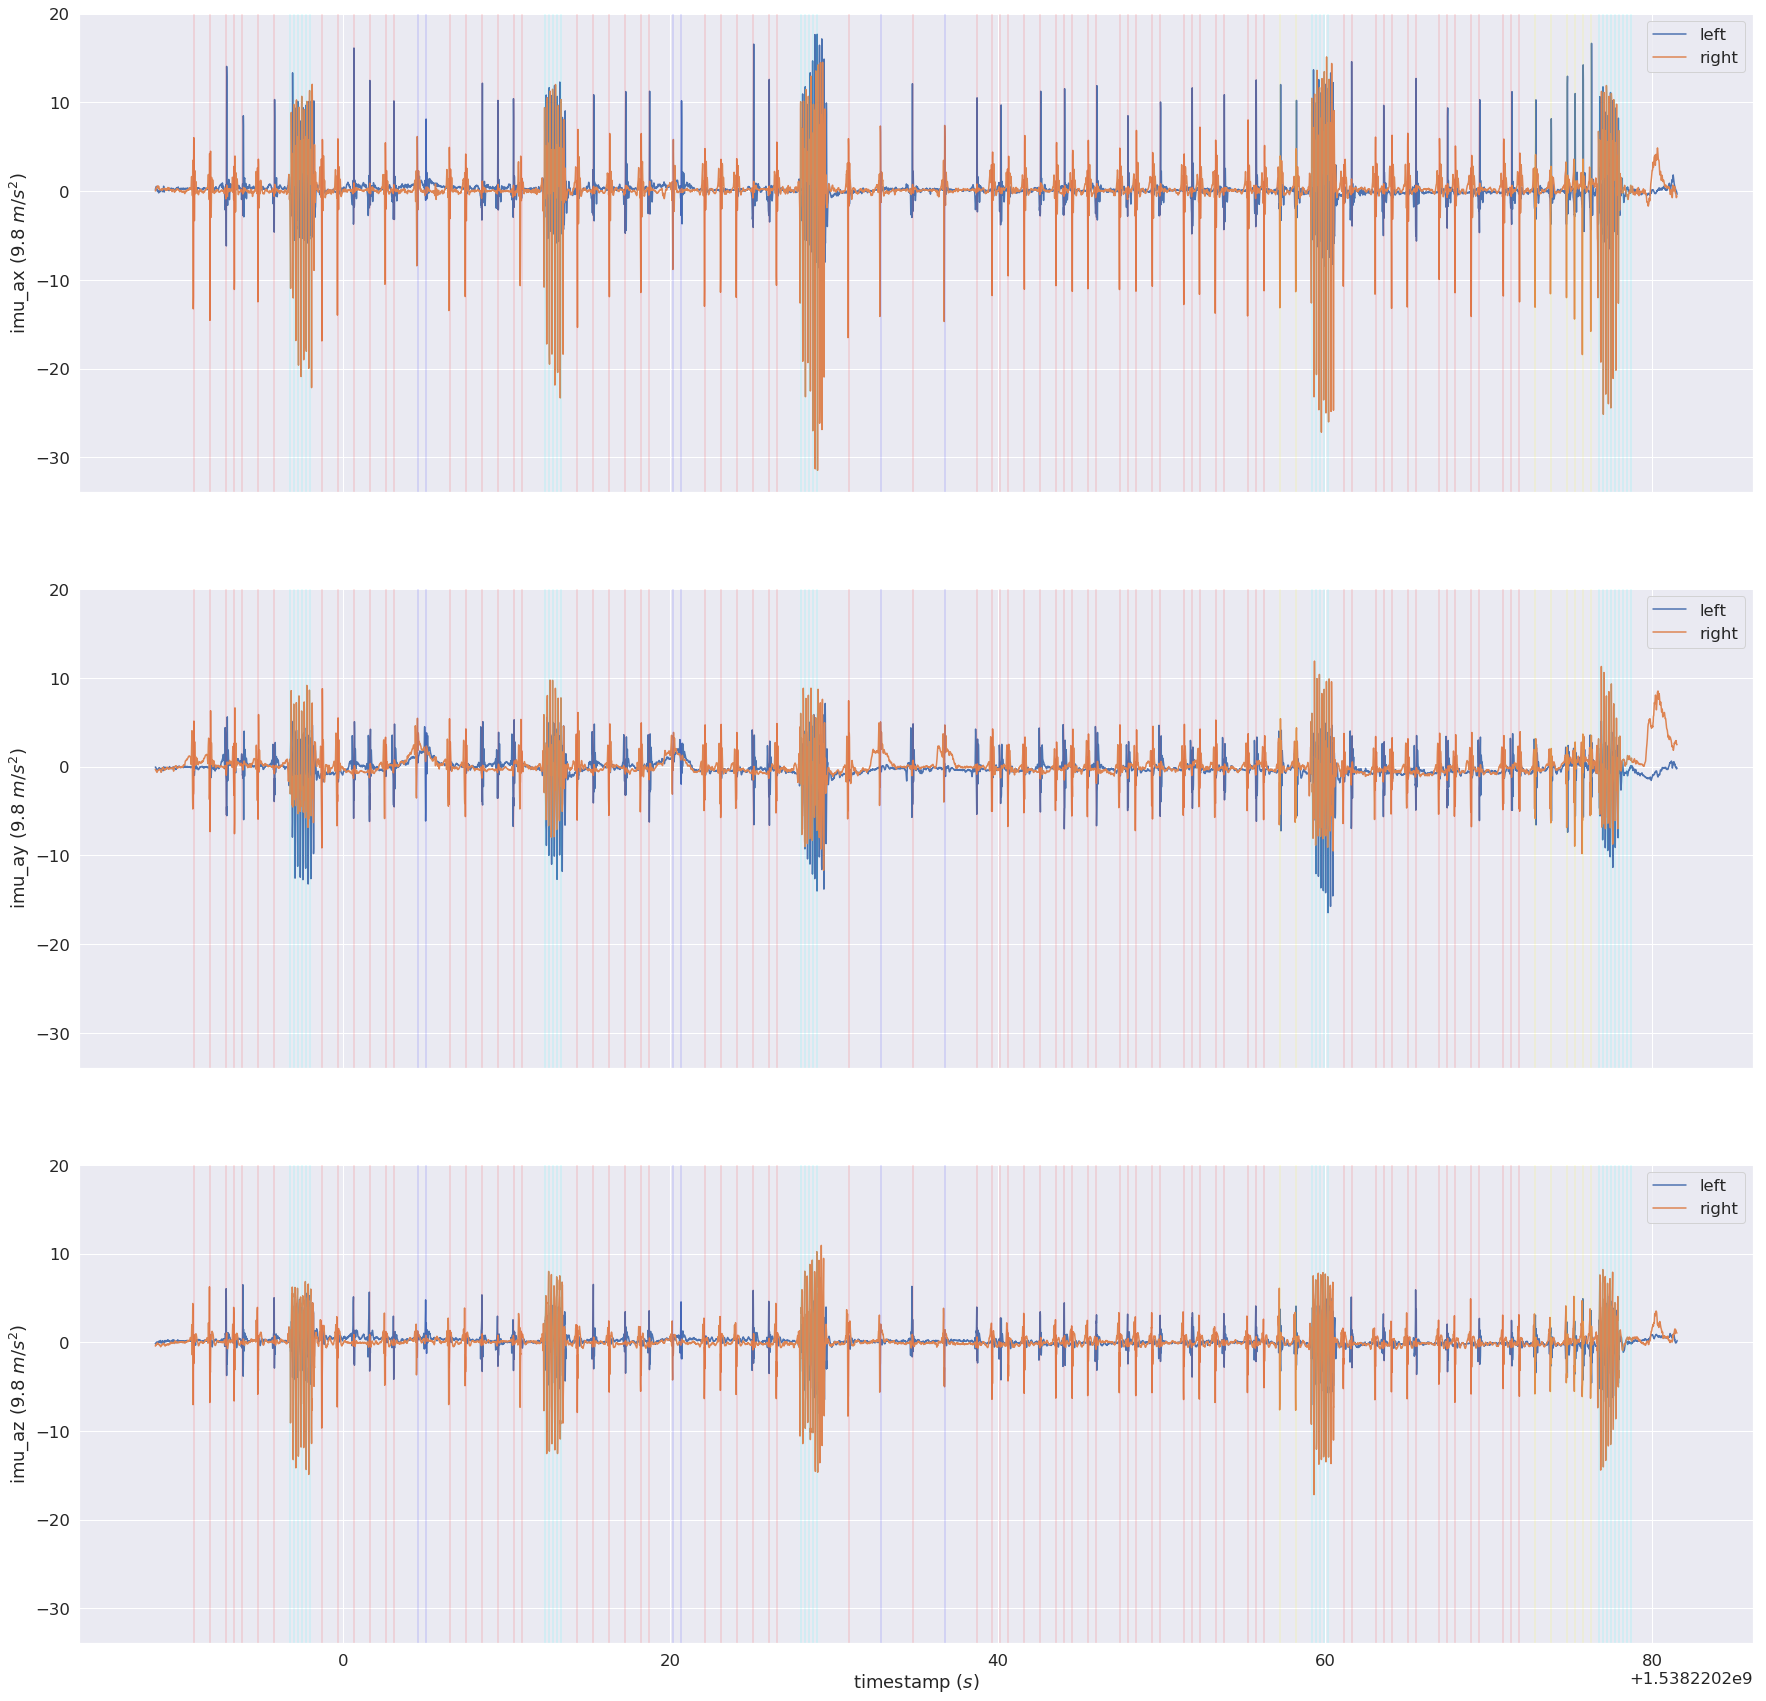

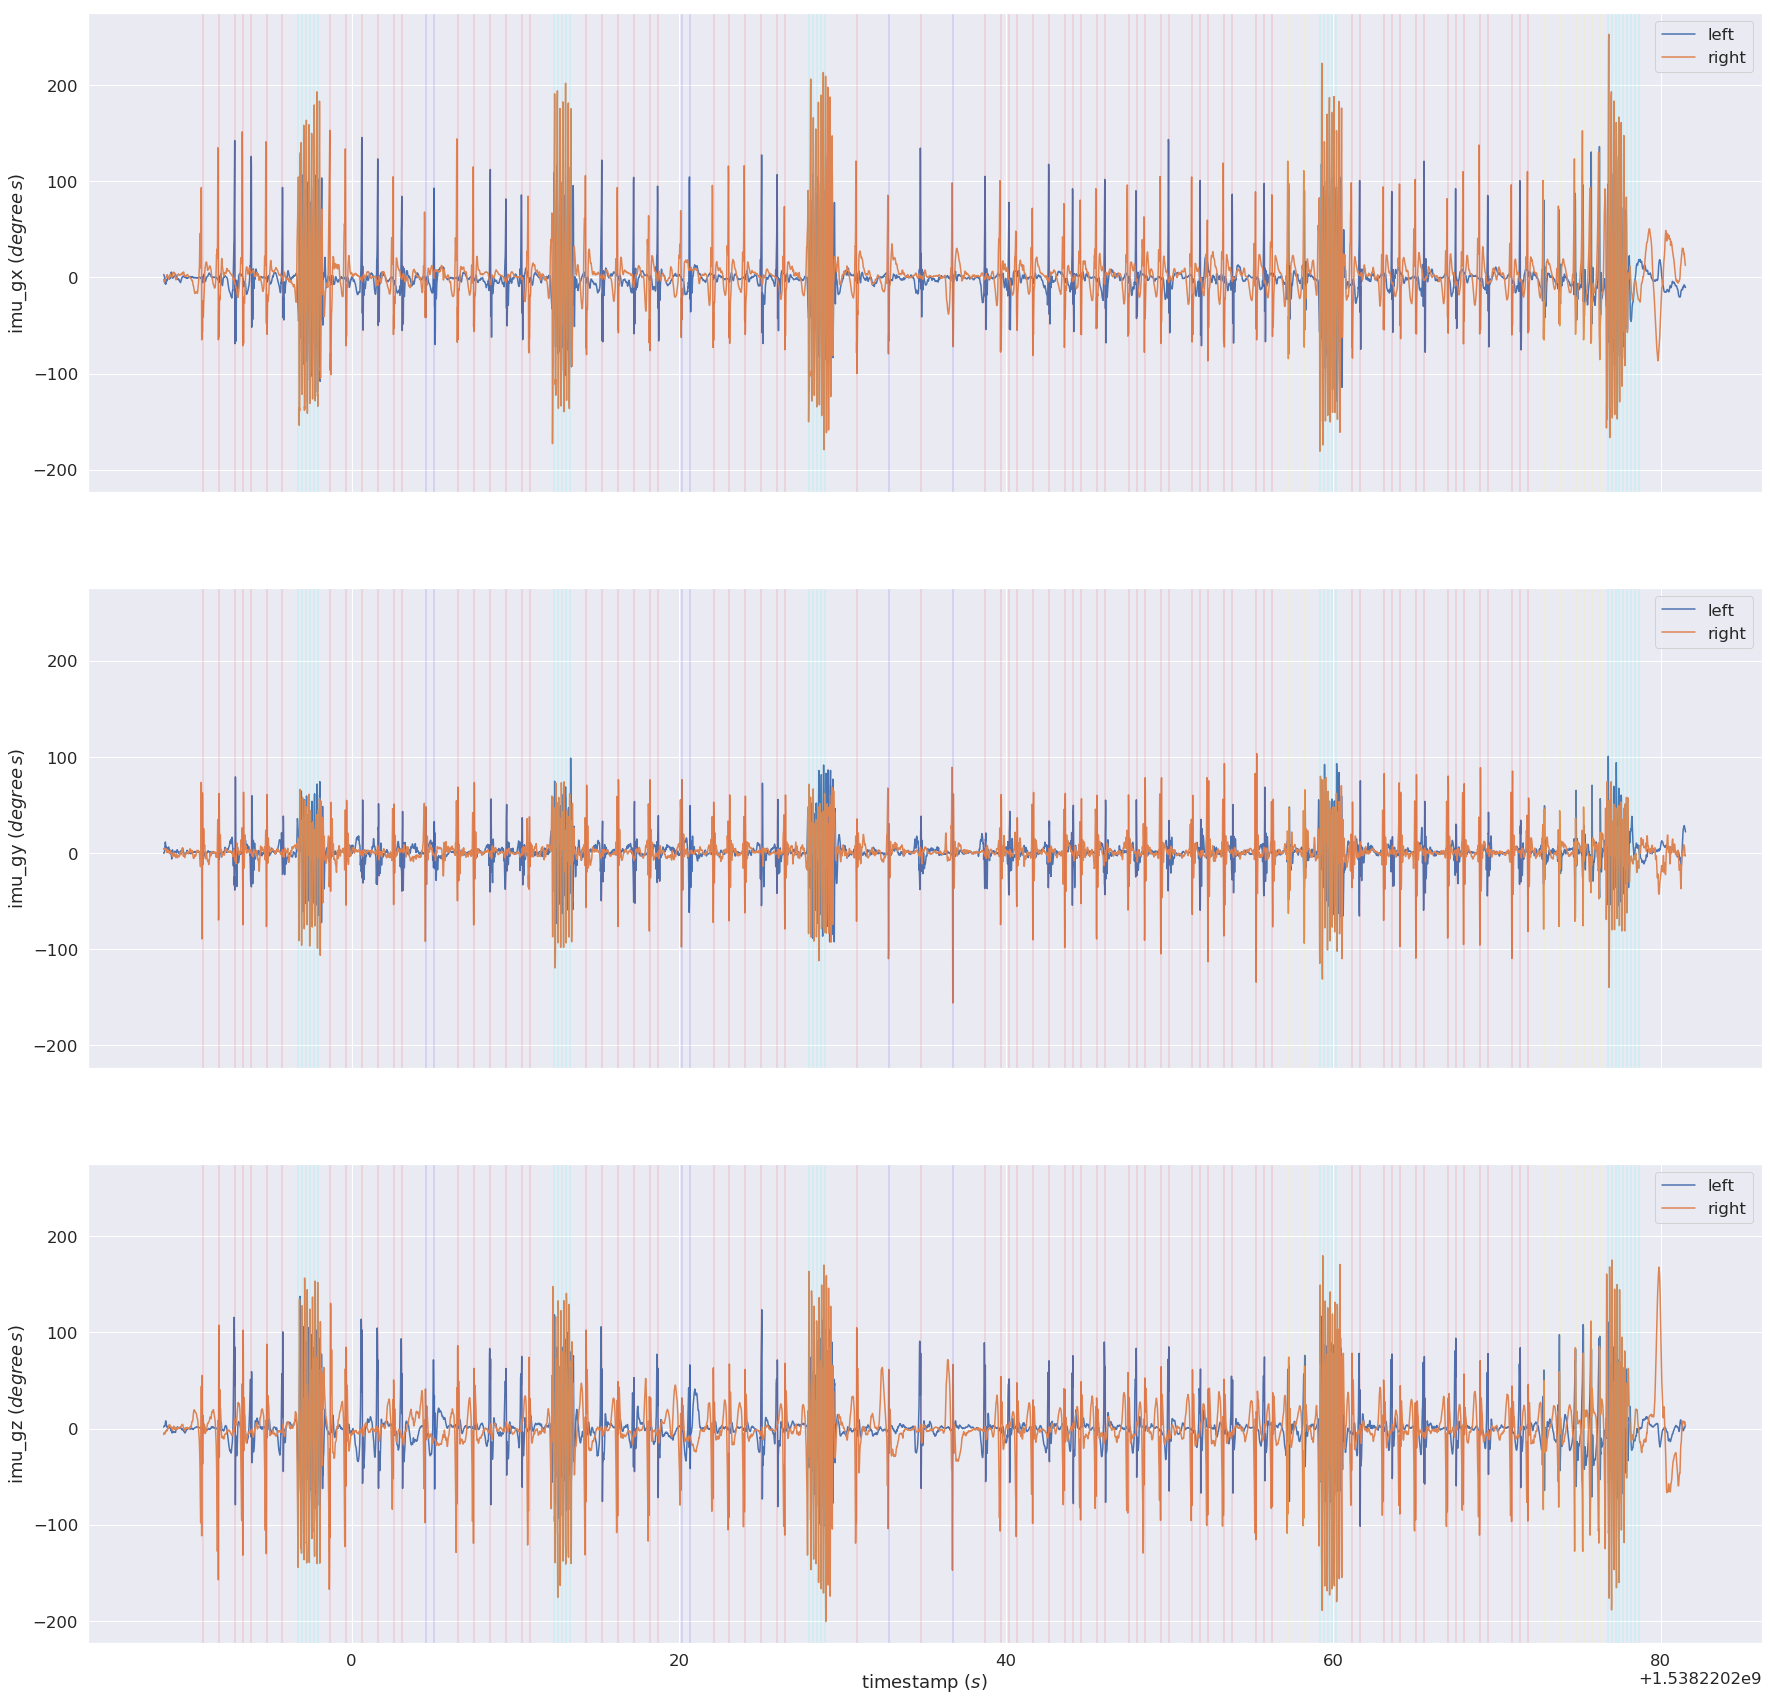

In [10]:
events = play.events
marks = []
for id_, _ in enumerate(events):
    event_time = events[id_][0]
    hit_type = transform_drum_note_hit_type(events[id_][1])
    if hit_type > 0:
        marks.append((event_time, tk.COLORS[hit_type]))
        
plot_raw_acc_signal(play.play_dict['L'], play.play_dict['R'], marks=marks)
plot_raw_gyr_signal(play.play_dict['L'], play.play_dict['R'], marks=marks)

## real-time

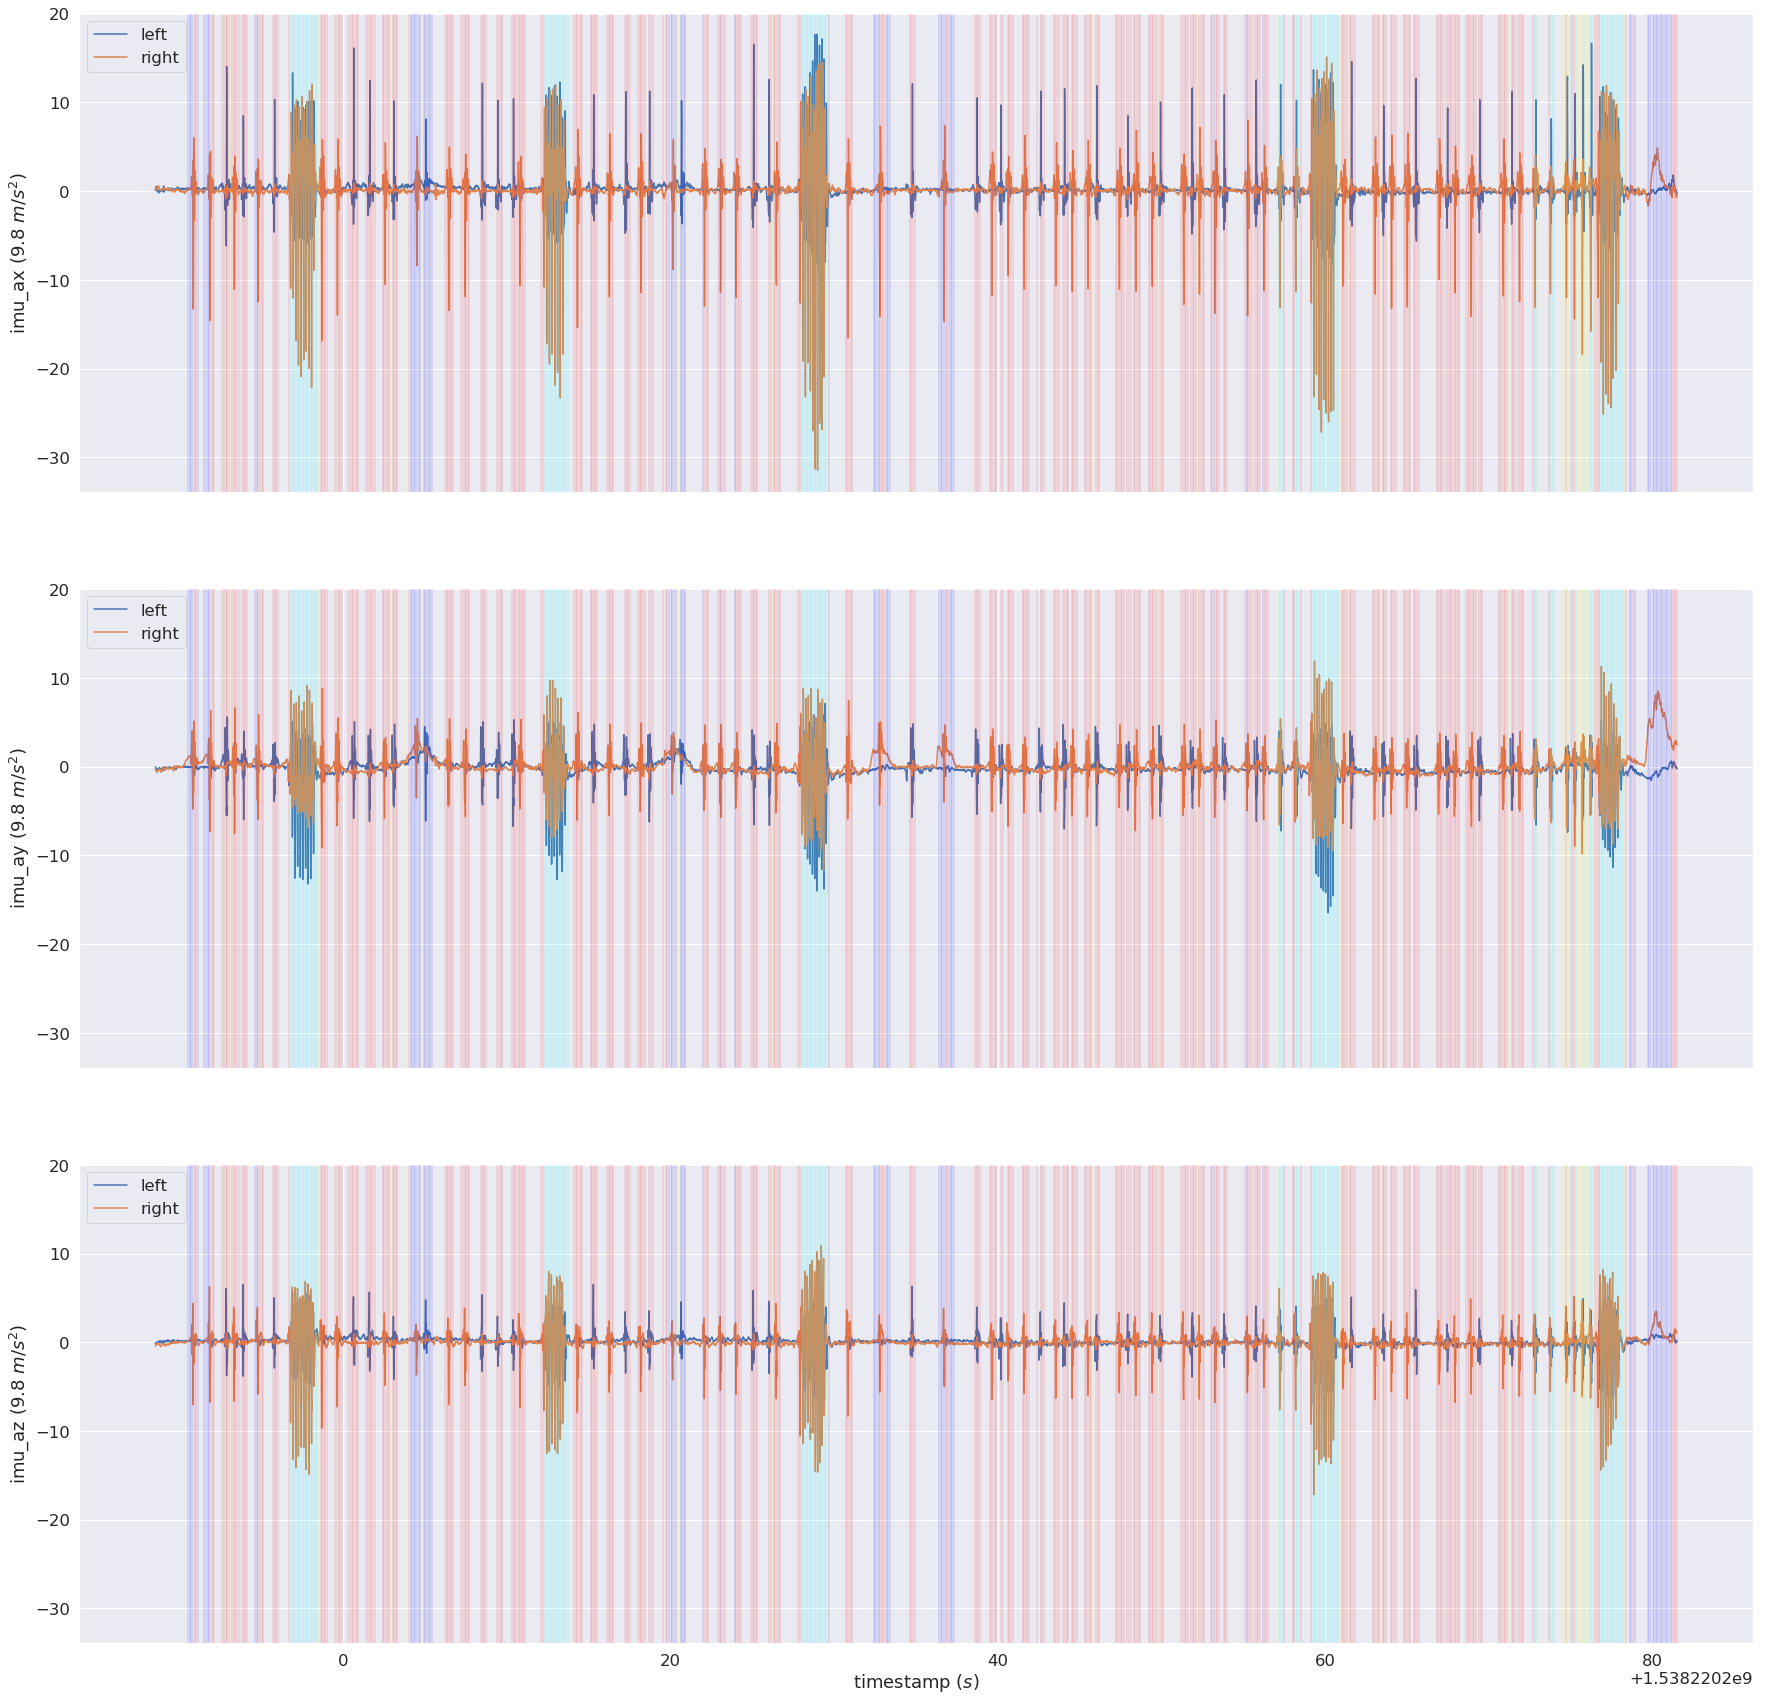

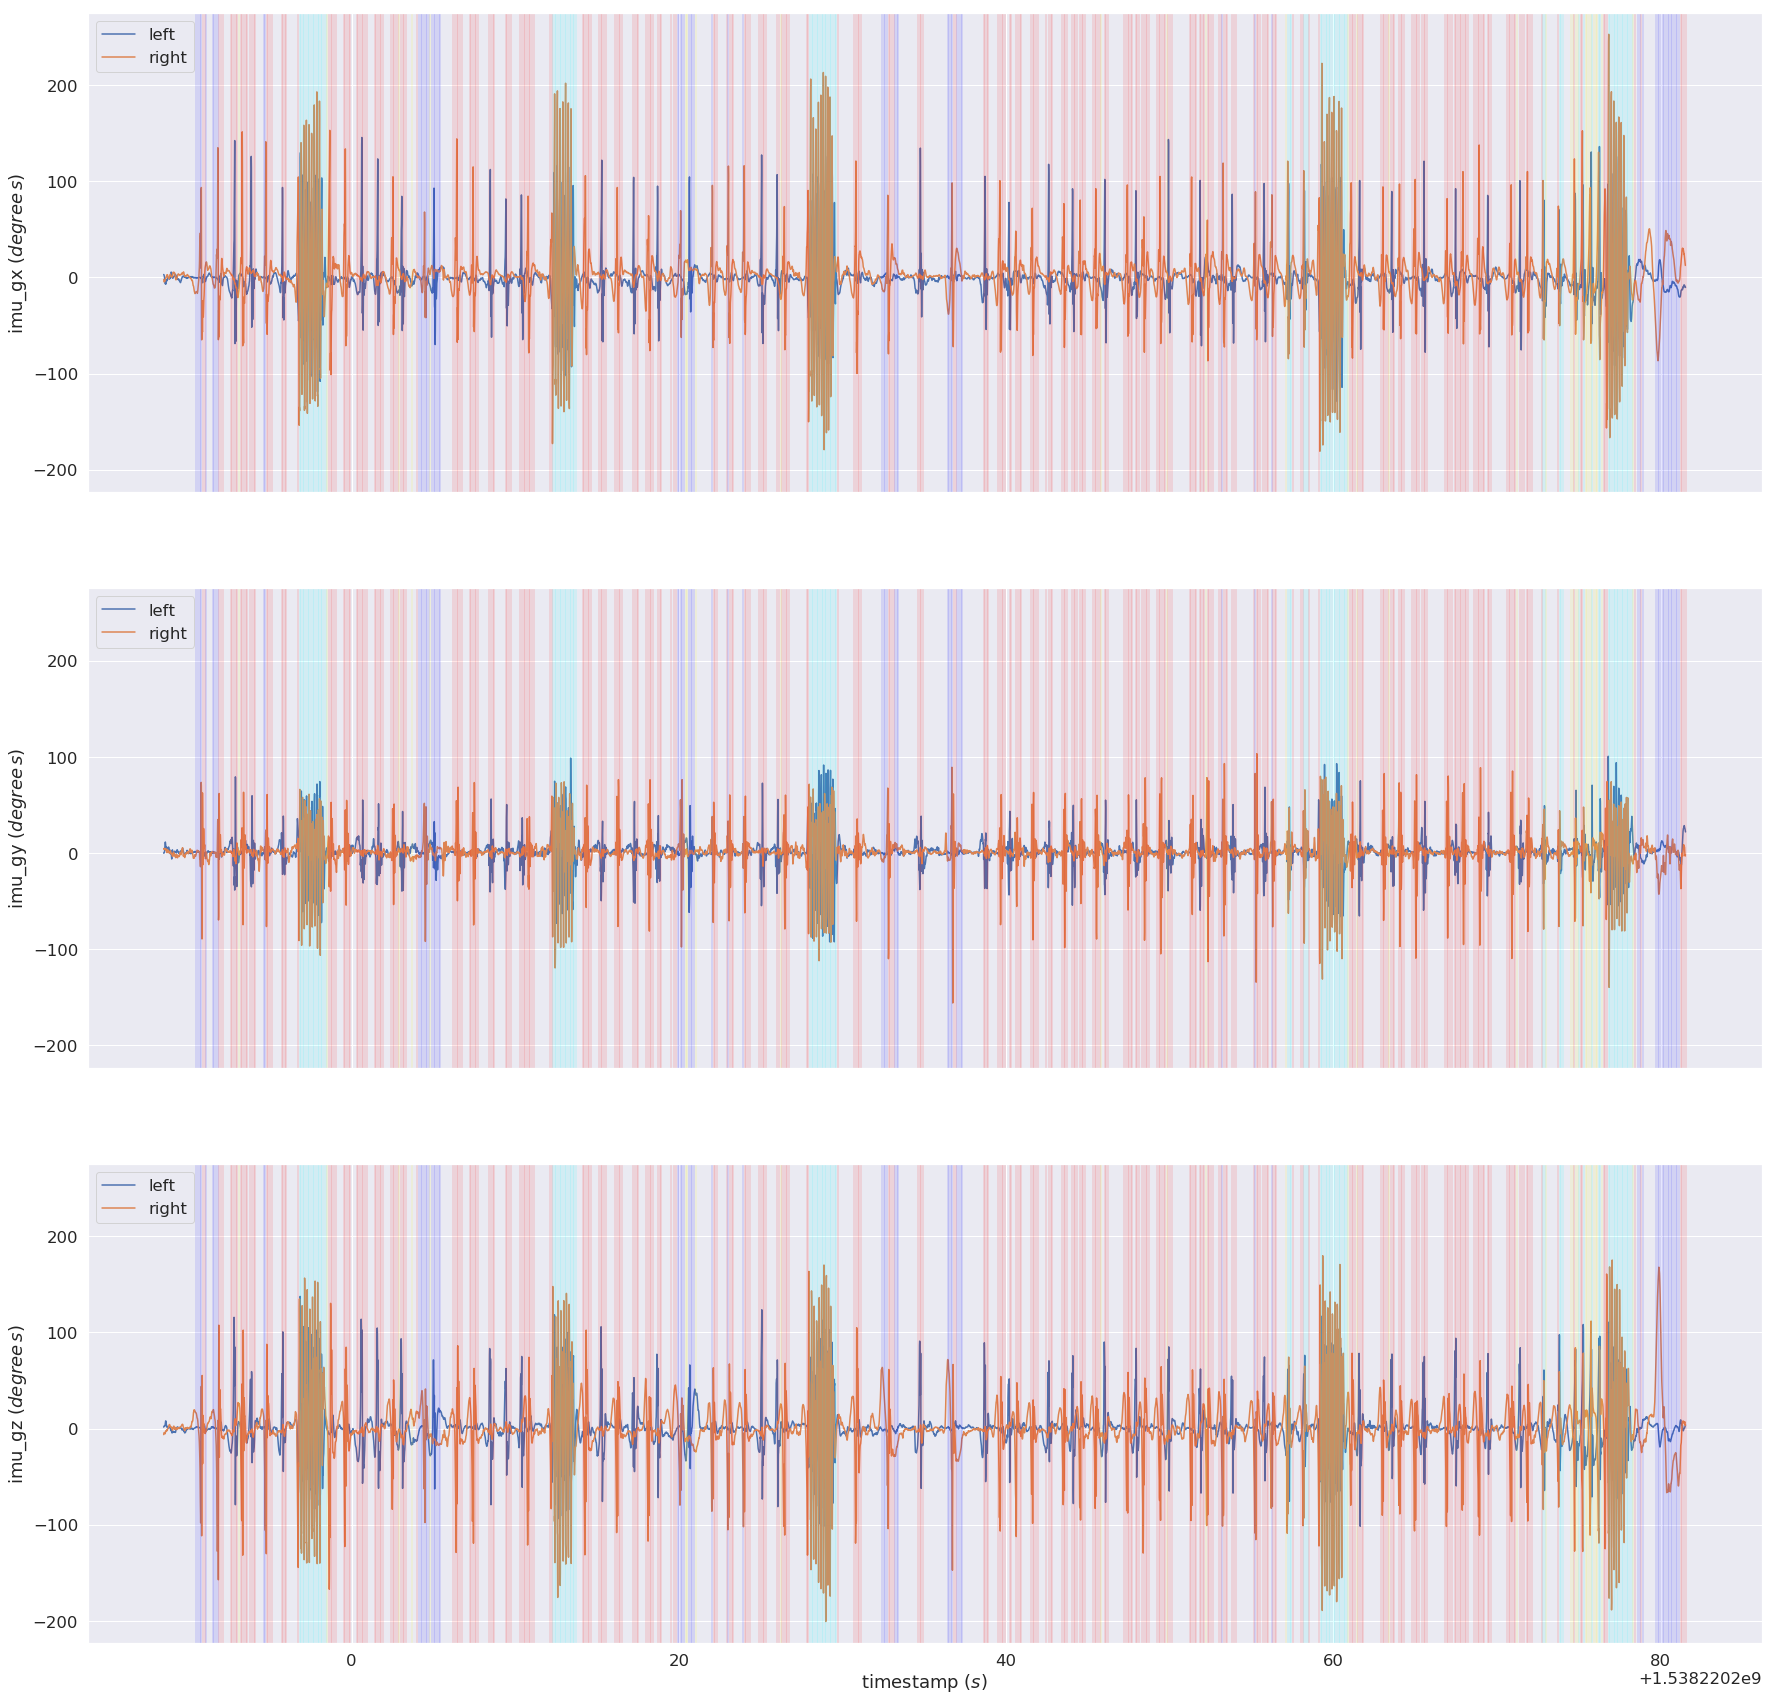

In [11]:
marks = []
for row_ in pred_df.values:
        event_time = float(row_[0])
        hit_type = transform_hit_type(int(row_[1]))
        if hit_type > 0:
            marks.append((event_time, tk.COLORS[hit_type]))
            
plot_raw_acc_signal(play.play_dict['L'], play.play_dict['R'], marks=marks)
plot_raw_gyr_signal(play.play_dict['L'], play.play_dict['R'], marks=marks)